# CS624 Final Project

*Presented by:*


*   Bryan Kors | bkors001@odu.edu | [bryan255.github.io](https://bryan255.github.io/#aboutme)
*   Dipendra Thapa Magar | dthap001@odu.edu | [dipendrathapamagar.github.io](https://dipendrathapamagar.github.io)
*   Calvin Hill | chill034@odu.edu |
*   Phillip Wilson | pwils008@odu.edu |

## Background
### The Problem
Given batch data from MovieLens,can we provide movie recommendations to movie viewers based on their historical ratings of movies?

### Dataset
The dataset was retrieved from TensorFlow and contains a set of movie ratings from the website MovieLens, which offer a movie recommendation service.Ratings are incremented in whole-star increments and span across 1682 movies, by 943 users. The dataset was collected and maintained by the reseach group GroupLens at the University of Minnesota and contains 100,000 records that include demographic data of users in addition to data on the movies and their ratings.

### Goal
The goal is to build a machine learning model with PySpark that can take historical viewing data and provide recommendations of movies to watch based on similar users viewing histories.

## Initial Data Loading & Preprocessing

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d98e2a8d01ff8a99bb122799049139c3f988b892be8d4b4b52f2d86a75483218
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as pyspark_sum, desc, explode
from pyspark.ml.feature import OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
# load movielens/100k-ratings dataset and dataset info

ds, ds_info = tfds.load(name='movielens/100k-ratings', with_info=True, shuffle_files=False, split='train')

# convert dataset to a dataframe

df = tfds.as_dataframe(ds, ds_info)
df.head()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/0.1.1.incompleteS2EA74/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'
1,25.0,"[4, 14]",b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5,b'entertainment',2.0,b'80525'
2,18.0,[4],b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17,b'student',4.0,b'55439'
3,50.0,"[5, 7]",b'56',b'Pulp Fiction (1994)',50.0,883326919,True,b'60',4,b'healthcare',4.0,b'06472'
4,50.0,"[10, 16]",b'895',b'Scream 2 (1997)',55.0,891409199,True,b'197',18,b'technician',3.0,b'75094'


In [ ]:
# snapshot of any null values and column datatypes

df.info()

<class 'tensorflow_datasets.core.as_dataframe.as_dataframe.<locals>.StyledDataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   bucketized_user_age    100000 non-null  float32
 1   movie_genres           100000 non-null  object 
 2   movie_id               100000 non-null  object 
 3   movie_title            100000 non-null  object 
 4   raw_user_age           100000 non-null  float32
 5   timestamp              100000 non-null  int64  
 6   user_gender            100000 non-null  bool   
 7   user_id                100000 non-null  object 
 8   user_occupation_label  100000 non-null  int64  
 9   user_occupation_text   100000 non-null  object 
 10  user_rating            100000 non-null  float32
 11  user_zip_code          100000 non-null  object 
dtypes: bool(1), float32(3), int64(2), object(6)
memory usage: 7.3+ MB


In [ ]:
## change column types

# change the timestamp int format to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s').dt.normalize()

# adjust boolean gender column to binary
df['user_gender'] = df['user_gender'].astype(int)

# decode byte format columns
byte_to_str = ['movie_id', 'movie_title', 'user_id', 'user_occupation_text', 'user_zip_code']
for c in byte_to_str:
    df[c] = df[c].str.decode('utf-8')

df.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],357,One Flew Over the Cuckoo's Nest (1975),46.0,1997-11-08,1,138,4,doctor,4.0,53211
1,25.0,"[4, 14]",709,Strictly Ballroom (1992),32.0,1997-09-30,1,92,5,entertainment,2.0,80525
2,18.0,[4],412,"Very Brady Sequel, A (1996)",24.0,1997-12-14,1,301,17,student,4.0,55439
3,50.0,"[5, 7]",56,Pulp Fiction (1994),50.0,1997-12-28,1,60,4,healthcare,4.0,06472
4,50.0,"[10, 16]",895,Scream 2 (1997),55.0,1998-04-01,1,197,18,technician,3.0,75094


In [ ]:
## encoding movie_genres by creating binary columns for each genre

total_genres = ds_info.features['movie_genres'].num_classes
genres = [ds_info.features['movie_genres'].int2str(i) for i in range(total_genres)]

genre_dict = dict(zip(genres, list(range(total_genres))))

for g in genres:
    df[g] = df['movie_genres'].apply(lambda x: 1 if genre_dict[g] in x else 0)

df.drop(columns=['movie_genres'], inplace=True)
df.head()

,bucketized_user_age,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,Unknown,War,Western,(no genres listed)
0,45.0,357,One Flew Over the Cuckoo's Nest (1975),46.0,1997-11-08,1,138,4,doctor,4.0,...,0,0,0,0,0,0,0,0,0,0
1,25.0,709,Strictly Ballroom (1992),32.0,1997-09-30,1,92,5,entertainment,2.0,...,0,0,0,1,0,0,0,0,0,0
2,18.0,412,"Very Brady Sequel, A (1996)",24.0,1997-12-14,1,301,17,student,4.0,...,0,0,0,0,0,0,0,0,0,0
3,50.0,56,Pulp Fiction (1994),50.0,1997-12-28,1,60,4,healthcare,4.0,...,0,0,0,0,0,0,0,0,0,0
4,50.0,895,Scream 2 (1997),55.0,1998-04-01,1,197,18,technician,3.0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
## create sparksession and transform pandas dataframe to spark dataframe

spark = SparkSession.builder.appName('movielens').getOrCreate()
spark_df = spark.createDataFrame(df.to_numpy(), df.columns.to_list())
spark_df.show(5)

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


+-------------------+--------+--------------------+------------+-------------------+-----------+-------+---------------------+--------------------+-----------+-------------+------+---------+---------+--------+------+-----+-----------+-----+-------+---------+------+----+-------+-------+-------+------+--------+-------+---+-------+------------------+
|bucketized_user_age|movie_id|         movie_title|raw_user_age|          timestamp|user_gender|user_id|user_occupation_label|user_occupation_text|user_rating|user_zip_code|Action|Adventure|Animation|Children|Comedy|Crime|Documentary|Drama|Fantasy|Film-Noir|Horror|IMAX|Musical|Mystery|Romance|Sci-Fi|Thriller|Unknown|War|Western|(no genres listed)|
+-------------------+--------+--------------------+------------+-------------------+-----------+-------+---------------------+--------------------+-----------+-------------+------+---------+---------+--------+------+-----+-----------+-----+-------+---------+------+----+-------+-------+-------+------

### Summary

The initial data loading was done with tensorflow-datasets into and converted to a pandas dataframe. There were no null values in the dataset but the d-type of the columns needed further processing before converting to a PySpark dataframe. This included:



*   Changing the timestamp to datetime format
*   Changing gender from boolean to binary
*   Decoding byte columns to strings
*   OneHotEncoding the genre column

With d-type conversion complete, a PySpark dataframe was created.



## Visualizations

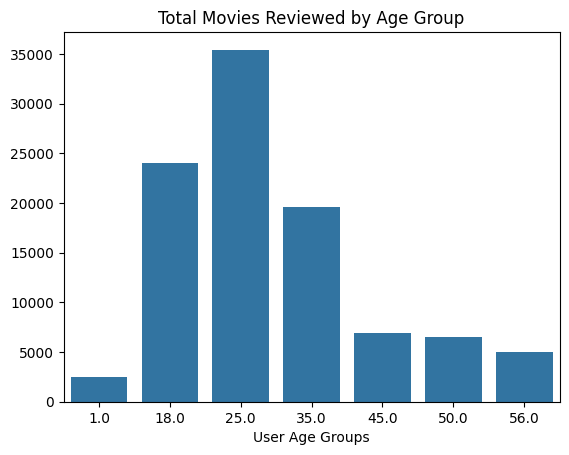

In [ ]:
sns.barplot(spark_df.groupBy('bucketized_user_age').count().sort('bucketized_user_age').toPandas(), x='bucketized_user_age', y='count')
plt.xlabel('User Age Groups')
plt.ylabel('')
plt.title('Total Movies Reviewed by Age Group')
plt.show()

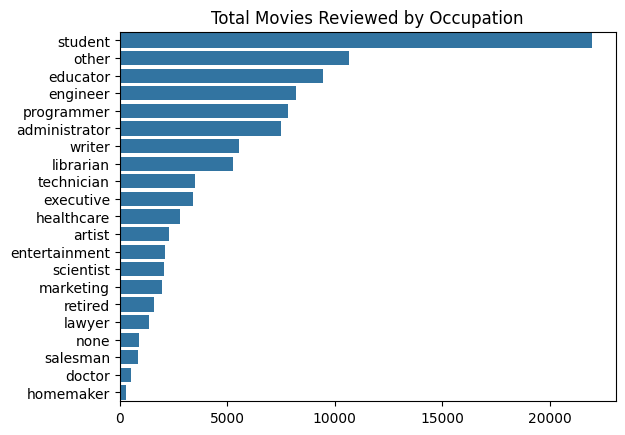

In [ ]:
sns.barplot(spark_df.groupBy('user_occupation_text').count().sort('count', ascending=False).toPandas(), y='user_occupation_text', x='count', orient='h')
plt.xlabel('')
plt.ylabel('')
plt.title('Total Movies Reviewed by Occupation')
plt.show()

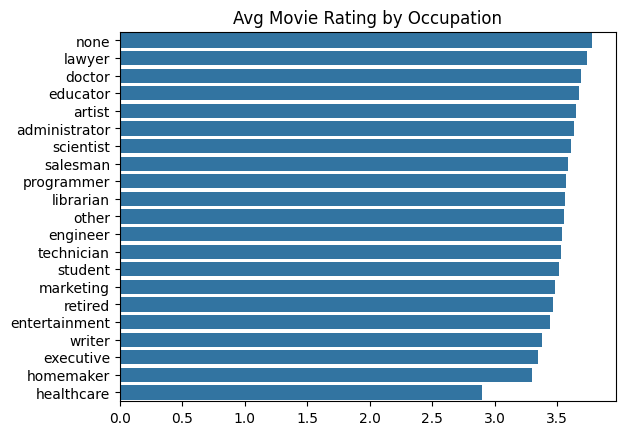

In [ ]:
sns.barplot(spark_df.groupBy('user_occupation_text').avg('user_rating').sort('avg(user_rating)', ascending=False).toPandas(), y='user_occupation_text', x='avg(user_rating)', orient='h')
plt.xlabel('')
plt.ylabel('')
plt.title('Avg Movie Rating by Occupation')
plt.show()

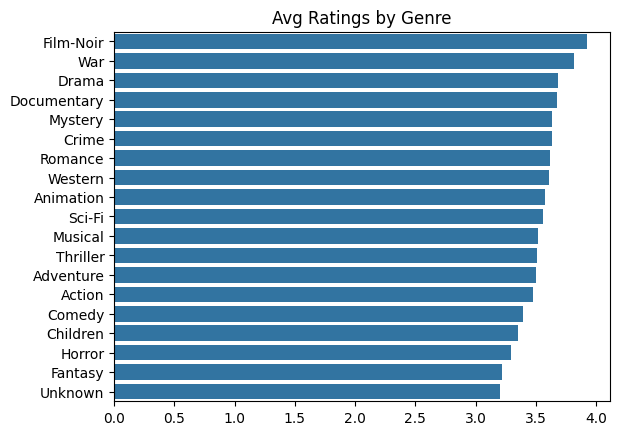

In [ ]:
d = dict().fromkeys(genres)

for key in d.keys():
    d[key] = spark_df.filter(col(key) == 1).agg({'user_rating' : 'avg'}).collect()[0][0]

temp_df = pd.DataFrame(zip(d.keys(), d.values()), columns=['Genre', 'Avg Rating']).dropna().sort_values(by=['Avg Rating'], ascending=False)
sns.barplot(temp_df, y='Genre', x='Avg Rating', orient='h')
plt.xlabel('')
plt.ylabel('')
plt.title('Avg Ratings by Genre')
plt.show()

### Summary

Seaborn and matplotlib are unable to read PySpark dataframes. A groupBy was done to aggregate several different views then converted to Pandas dataframes for seaborn and matplotlib. These visuals include:

*   Review totals by age group
  *   Most reviews come from the 25 - 34 age
  *   Least reviews come from the < 18 age
*   Total movies reviewed by occupation
  *   Students largely outweigh other occupations
  *   Salesmen, doctors, and homemakers are among the bottom three occupations
*   Avg movie rating by occupation
  *   Most ratings range between 3 and 3.5
  *   "None" and Lawyer occupations are the top two with average ratings of ~3.5
  *   Healthcare is the only occupation averaging ratings below 3.0 at ~2.9
*   Avg ratings by genre
  *   Film-noir has the highest ratings on average while unknown and fantasy genres are among the lowest average ratings


## MLib

In [ ]:
# OneHotEncoding of the user age groups and the user occupations for linear regression model

ohe = OneHotEncoder(inputCols=['bucketized_user_age', 'user_occupation_label'], outputCols=['ohe_bucketized_age', 'ohe_occupation'])
model = ohe.fit(spark_df).setOutputCols(['ohe_bucketized_age', 'ohe_occupation'])
spark_df = model.transform(spark_df)

spark_df.show(5)

+-------------------+--------+--------------------+------------+-------------------+-----------+-------+---------------------+--------------------+-----------+-------------+------+---------+---------+--------+------+-----+-----------+-----+-------+---------+------+----+-------+-------+-------+------+--------+-------+---+-------+------------------+------------------+---------------+
|bucketized_user_age|movie_id|         movie_title|raw_user_age|          timestamp|user_gender|user_id|user_occupation_label|user_occupation_text|user_rating|user_zip_code|Action|Adventure|Animation|Children|Comedy|Crime|Documentary|Drama|Fantasy|Film-Noir|Horror|IMAX|Musical|Mystery|Romance|Sci-Fi|Thriller|Unknown|War|Western|(no genres listed)|ohe_bucketized_age| ohe_occupation|
+-------------------+--------+--------------------+------------+-------------------+-----------+-------+---------------------+--------------------+-----------+-------------+------+---------+---------+--------+------+-----+--------

In [ ]:
# creating a single vector of the encoded variables for linear regression inputs called 'features'

vector_columns = genres + ['user_gender', 'ohe_bucketized_age', 'ohe_occupation']

assembler = VectorAssembler(inputCols=vector_columns, outputCol='features')
assembled_df = assembler.transform(spark_df)

# converting user_id and movie_id columns to int type for ALS model
assembled_df = assembled_df.withColumn('user_id', col('user_id').cast('int'))
assembled_df = assembled_df.withColumn('movie_id', col('movie_id').cast('int'))

assembled_df.show()

+-------------------+--------+--------------------+------------+-------------------+-----------+-------+---------------------+--------------------+-----------+-------------+------+---------+---------+--------+------+-----+-----------+-----+-------+---------+------+----+-------+-------+-------+------+--------+-------+---+-------+------------------+------------------+---------------+--------------------+
|bucketized_user_age|movie_id|         movie_title|raw_user_age|          timestamp|user_gender|user_id|user_occupation_label|user_occupation_text|user_rating|user_zip_code|Action|Adventure|Animation|Children|Comedy|Crime|Documentary|Drama|Fantasy|Film-Noir|Horror|IMAX|Musical|Mystery|Romance|Sci-Fi|Thriller|Unknown|War|Western|(no genres listed)|ohe_bucketized_age| ohe_occupation|            features|
+-------------------+--------+--------------------+------------+-------------------+-----------+-------+---------------------+--------------------+-----------+-------------+------+--------

In [ ]:
# linear regression model build and rsme evaluation

(training, test) = assembled_df.randomSplit([0.7, 0.3], seed=42)

lr = LinearRegression(featuresCol='features', labelCol='user_rating', regParam=.01, standardization=True)
model = lr.fit(training)

evaluator = RegressionEvaluator(metricName='rmse', labelCol='user_rating', predictionCol='prediction')
pred = model.transform(test)
rmse = evaluator.evaluate(pred)
rmse

1.1007813795867538

In [ ]:
# ALS model to compare

als = ALS(maxIter=10, userCol='user_id', ratingCol='user_rating', itemCol='movie_id', coldStartStrategy='drop')
model = als.fit(training)

pred = model.transform(test)
rmse = evaluator.evaluate(pred)
rmse

0.9297462172424733

In [ ]:
print(f'ALS Rank: {als.getRank()}, regParam: {als.getRegParam()}')

ALS Rank: 10, regParam: 0.1


The ALS model with its default attributes provides a better RMSE than the linear model. We will go forward with the ALS model and perform some hyperparameter tuning to see if we can improve the RMSE of the model.

In [ ]:
reg_param_list = np.arange(.08, .13, .01)
rank_list = np.arange(8, 13, 1)

min_err = np.inf
best_model = None
best_reg_param = 0
best_rank = 0

for rank in rank_list:
  for reg in reg_param_list:
    als = ALS(maxIter=10, regParam=reg, userCol='user_id', ratingCol='user_rating', itemCol='movie_id', coldStartStrategy='drop')
    model = als.fit(training)

    pred = model.transform(test)
    rmse = evaluator.evaluate(pred)

    if rmse < min_err:
      min_err = rmse
      best_model = model
      best_reg_param = reg
      best_rank = rank

print(f'Best Model\n\nRMSE: {min_err}\nRank: {best_rank}\nReg Parameter: {best_reg_param:.2f}')

Best Model

RMSE: 0.9252197859817874
Rank: 8
Reg Parameter: 0.12


In [ ]:
# provide an example output with the best model on the entire dataset

spark_df = spark_df.withColumn('user_id', col('user_id').cast('int'))
spark_df = spark_df.withColumn('movie_id', col('movie_id').cast('int'))

example_user = 276

example_top_movies = spark_df.filter(col('user_id') == example_user).sort(desc('user_rating')).select('movie_title', 'user_rating').take(10)

print(f'Below are 10 of the highest rated movies for user {example_user}:\n')

for row in example_top_movies:
  print(f"{row['movie_title']} - {row['user_rating']}")

recommendations = best_model.recommendForUserSubset(spark_df.filter(col('user_id') == example_user), 5).collect()

rec_df = spark.createDataFrame(recommendations)
rec_df = rec_df.select(col('user_id'), explode('recommendations').alias('recommendations'))
rec_df = rec_df.select(col('user_id'), col('recommendations.movie_id').alias('movie_id'), col('recommendations.rating').alias('predicted_rating'))

rec_df = rec_df.join(spark_df.select('movie_id', 'movie_title').distinct(), 'movie_id', 'left').sort(desc('predicted_rating')).collect()

print(f'\n\nBased on user {example_user} movie history, below are five recommended movies:\n')

for row in rec_df:
  print(f"{row['movie_title']} ({row['predicted_rating']:.2f} Predicted Rating)")

Below are 10 of the highest rated movies for user 276:

Princess Bride, The (1987) - 5.0
Raising Arizona (1987) - 5.0
Raging Bull (1980) - 5.0
Twelve Monkeys (1995) - 5.0
Dead Man Walking (1995) - 5.0
Braveheart (1995) - 5.0
Blade Runner (1982) - 5.0
Fargo (1996) - 5.0
Empire Strikes Back, The (1980) - 5.0
Sound of Music, The (1965) - 5.0


Based on user 276 movie history, below are five recommended movies:

Mina Tannenbaum (1994) (5.61 Predicted Rating)
Angel Baby (1995) (4.91 Predicted Rating)
Saint of Fort Washington, The (1993) (4.83 Predicted Rating)
Boys, Les (1997) (4.71 Predicted Rating)
Usual Suspects, The (1995) (4.69 Predicted Rating)


## Project Summary

### Challenges & Future Work:

Once preprocessing was complete and the spark dataframe created, two models were tested to see which was better performing initially. The ALS model provided a lower RMSE than the Linear Regression.

Hyperparameter tuning was conducted on the ALS model to determine if a better model could be created. This was our first challenge. The hyperparameter tuning cell took nearly 6 minutes to run five options of two different parameters. If the need were to tune more parameters or other models, Google Colab would need be an efficient choice.

An additional challenge would be larger datasets. While this was trained on the 100K dataset, there are much larger movie lens datasets available (i.e. 25m dataset). These datasets are loaded through tensorflow-datasets. If loaded via CSV, they could get loaded directly into a PySpark dataframe rather than timely preprocessing through Pandas.

### LLM Project:

ALS is a collaborative filtering model used for making recommendations. This can be used in tandem with the financial advisor LLM. The ALS can use any identifiers such as "customer_id" in place of userCol, "stock_id" (with reference to name) in place of itemCol, and 'return' in place of ratingCol to create a recommender for stocks. The LLM can use the recommendations to generate explanations and summaries of these recommendations.